In [1]:
import os

import cv2
import numpy as np

import face_features

feature_extractor = face_features.FaceFeatureExtractor()

### Problem1: Finding the correct person using 1000 features will take forever
Let's try getting features for tons of people to see if it is feasible to do some dimensionality reduction.

### Problem2: We don't know at what distance it is safe to say these are the same people
We can use a labeled dataset to figure out what is a safe distance.

### Approach: Find a labeled dataset with a lot of different people
This is what I'm using: http://vis-www.cs.umass.edu/lfw/#download

### Let's go through every image and calculate its features
Let's constantly dump it into a file just in case.

In [2]:
# Load image.
img_paths = []
for dirpath, dirname, filenames in os.walk('./lfw'):
    for filename in filenames:
        if filename.endswith('.jpg'):
            img_paths.append([filename, dirpath.split('/')[-1]])
        else:
            print(filename)
img_paths = sorted(img_paths)
len(img_paths)

13233

In [3]:
for i, path in enumerate(img_paths):
    try:
        im = cv2.imread('./lfw/%s/%s' % (path[1], path[0]))
        feat = feature_extractor.getFeatures(im)[0]
        if i == 0:
            features = np.array([feat])
            labels = np.array([path[1]])
        else:
            features = np.concatenate((features, [feat]))
            labels = np.concatenate((labels, [path[1]]))
    except:
        print(' Error at %s' % i)
np.save('features.npy', features)
np.save('labels.npy', labels)

 Error at 8493


### Let's check what is the cosine distance between a person and everybody else

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [5]:
def show_image(im_num):
    im = cv2.imread('./lfw/%s/%s' % (img_paths[im_num][1], img_paths[im_num][0]))
    plt.imshow(im)

In [6]:
similarities = cosine_similarity(features)

In [8]:
# Let's go through all combinations storing distances separated by 
# whether these are the same people or not.
same_people = []
diff_people = []
for i, distances in enumerate(similarities):
    for j, distance in enumerate(distances):
        if i == j:
            break
        if labels[i] == labels[j]:
            same_people.append(distance)
        else:
            diff_people.append(distance)
same_people = np.array(same_people)
diff_people = np.array(diff_people)

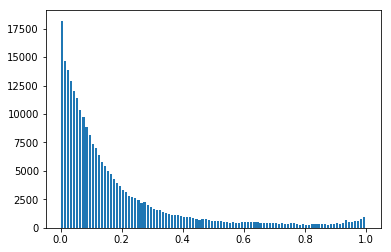

In [9]:
hist, bins = np.histogram(same_people, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

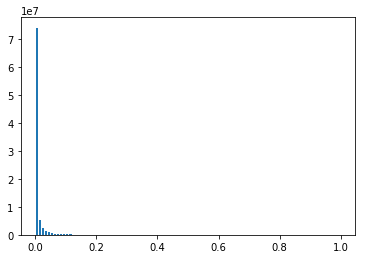

In [10]:
hist, bins = np.histogram(diff_people, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [11]:
def benchmark_threshold(threshold, same_dists, diff_dists):
    same = 100. * np.sum(same_dists > threshold)/len(same_dists)
    diff = 100. * np.sum(diff_dists > threshold)/len(diff_dists)
    print('%s%% of same faces identified correctly and %s%% of different face identified wrong' % (same, diff))

In [12]:
benchmark_threshold(.1, same_people, diff_people)

50.40824582260088% of same faces identified correctly and 1.2355528510308378% of different face identified wrong


In [13]:
benchmark_threshold(.05, same_people, diff_people)

70.4428373291064% of same faces identified correctly and 3.402103969526442% of different face identified wrong


In [44]:
a

[array([4.8883416e-05, 5.2162200e-06, 1.7355617e-04, ..., 2.5648349e-06,
        7.1046543e-06, 4.6974150e-05], dtype=float32),
 array([9.7766831e-05, 1.0432440e-05, 3.4711233e-04, ..., 5.1296697e-06,
        1.4209309e-05, 9.3948300e-05], dtype=float32)]